In [ ]:
%matplotlib inline

#import gym
import matplotlib
import numpy as np
import itertools
from envs.Hospitalenv import Hostipal
import matplotlib.pyplot as plt
from envs import Plotting
from collections import defaultdict
import sys
import seaborn as sns
import timeit

matplotlib.style.use('ggplot')

In [ ]:
lam=6 ## for generating request from possion distribution with Lambda = lam
beds=100

env=Hostipal(beds,lam)

In [ ]:
def make_epsilon_greedy_policy(Q, epsilon, nA,env):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
       
        A = np.ones(env.m-env.OccupiedBed, dtype=float) * epsilon / (env.m-env.OccupiedBed)
        
        #print("OccupiedBed",env.OccupiedBed)
        
        #print("A",A)
        
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn


In [ ]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.1, epsilon=0.5):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    nA = env.m
    #print(nA)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(nA))

    #print(len(Q))
    # Keeps track of useful statistics
    stats = Plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, nA,env)
    
    for i_episode in range(num_episodes)  :
        
        epsilon /= (i_episode + 1)
        
        # Print out which episode we're on, useful for debugging.
        if ((i_episode + 1) % 500 == 0):
            print("Episode {}/{}.".format(i_episode + 1, num_episodes),flush=True)
            sys.stdout.flush()
        
        #print("reset")
        state = env.reset()
        terminated = False
        
        for t in itertools.count():

            #sys.stdout.write('\r'+str(t))
            
            request=max(1,env.request())
            #print("request",request)
            # sample the action from the epsilon greedy policy
            action = min(np.random.choice(env.m-env.OccupiedBed, p=policy(state)),request)
            #sys.stdout.write('actions --> \r'+ env.possibleaction[action])
            
            
            #print("action :",action)
            
            # Perform the action -> Get the reward and observe the next state
            #print("Before",env.getAgentRowAndColoumn(),"action",env.possibleaction[action])
            new_state, reward, terminated, old_state = env.step(action)
            #print("request",request,"action",action,"old_state",old_state,"new_state",new_state)
            
#             print("reward :",reward)
#             print("old state",old_state)
#             print("action",action)
#             print("new_state :",new_state)
#             print('-'*100)

            
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            # value that we should have got
            # The Q-learning target policy is a greedy one, hence the `max`
            td_target = reward + discount_factor * max(Q[new_state])
            td_error = td_target - Q[state][action]
            
            # Q-learning update
            Q[state][action] += alpha * td_error
            
            # update current state
            state = new_state
            
            if terminated:
                break
    
    return Q, stats

In [ ]:
Q, stats = q_learning(env, 1000)

Episode 500/1000.
Episode 1000/1000.


In [ ]:
Q

defaultdict(<function __main__.q_learning.<locals>.<lambda>()>,
            {0: array([ 18.0854877 ,  73.68413759, 100.40695233, 113.44376504,
                    117.97680512, 125.74964121, 105.68373631, 106.87030617,
                    104.00970753,  84.47483561,  57.09342816,  18.89756508,
                     22.77359538,   6.88593443,   0.        ,   0.34860637,
                      0.        ,   0.        ,   0.        ,   0.        ,
                      0.        ,   0.        ,   0.        ,   0.        ,
                      0.        ,   0.        ,   0.        ,   0.        ,
                      0.        ,   0.        ,   0.        ,   0.        ,
                      0.        ,   0.        ,   0.        ,   0.        ,
                      0.        ,   0.        ,   0.        ,   0.        ,
                      0.        ,   0.        ,   0.        ,   0.        ,
                      0.        ,   0.        ,   0.        ,   0.        ,
                     

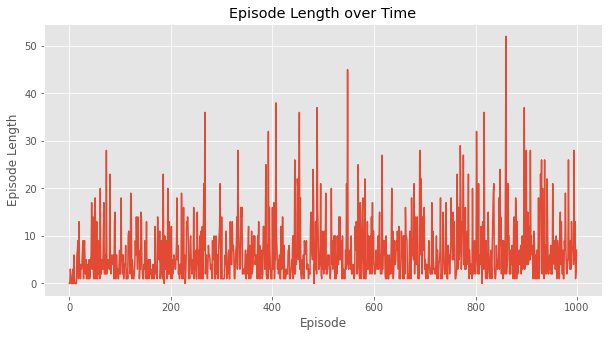

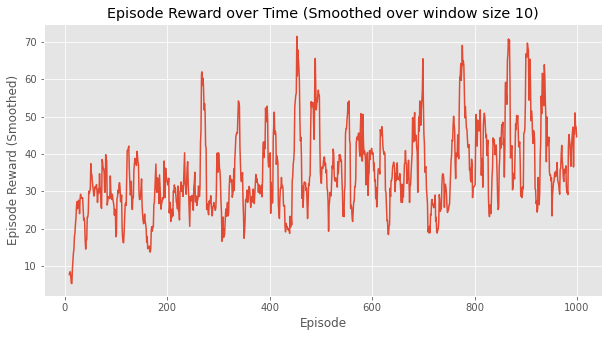

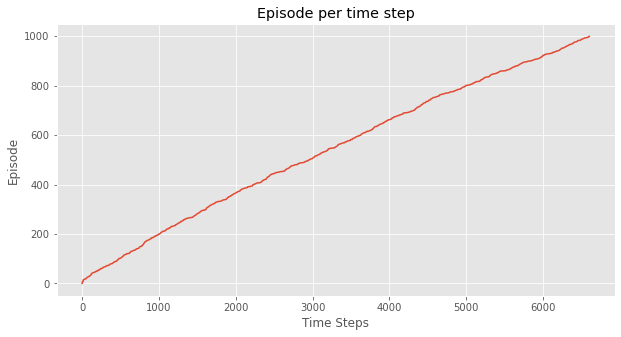

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [ ]:
Plotting.plot_episode_stats(stats)

In [ ]:
state_action=dict()
q_value=dict()
for i in Q.keys():
    state_action[i]=np.argmax(Q[i])
    q_value[i]=np.max(Q[i])

In [ ]:
for i in sorted(state_action.keys()):
    print("No of bed occupied",i,"Assign Beds",state_action[i])

No of bed occupied 0 Assign Beds 5
No of bed occupied 1 Assign Beds 5
No of bed occupied 2 Assign Beds 5
No of bed occupied 3 Assign Beds 6
No of bed occupied 4 Assign Beds 1
No of bed occupied 5 Assign Beds 6
No of bed occupied 6 Assign Beds 0
No of bed occupied 7 Assign Beds 0
No of bed occupied 8 Assign Beds 4
No of bed occupied 9 Assign Beds 3
No of bed occupied 10 Assign Beds 4
No of bed occupied 11 Assign Beds 4
No of bed occupied 12 Assign Beds 0
No of bed occupied 13 Assign Beds 5
No of bed occupied 14 Assign Beds 3
No of bed occupied 15 Assign Beds 0
No of bed occupied 16 Assign Beds 4
No of bed occupied 17 Assign Beds 6
No of bed occupied 18 Assign Beds 0
No of bed occupied 21 Assign Beds 5


In [ ]:
for i in sorted(q_value.keys()):
    print("i",i,"action",q_value[i])

i 0 action 125.74964120900255
i 1 action 123.68200320747292
i 2 action 124.88203503839024
i 3 action 126.33586278348282
i 4 action 126.27149405246297
i 5 action 129.20945972135493
i 6 action 127.53535929330182
i 7 action 127.6222165361852
i 8 action 131.3005293289824
i 9 action 127.41616715139499
i 10 action 126.93790564729248
i 11 action 121.42677475471001
i 12 action 108.1811461282486
i 13 action 68.85934430361485
i 14 action 56.810019571840385
i 15 action 40.015255321871
i 16 action 13.581973646553031
i 17 action 8.444071014788886
i 18 action 19.32303908790866
i 21 action 12.517637316921325
